In [130]:
### Import libraries
print('Import libraries')
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split

Import libraries


In [131]:
### Remove warnings
print('Remove warnings')
def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category = DeprecationWarning)

'''
TF_CPP_MIN_LOG_LEVEL = 0 to all logs .
TF_CPP_MIN_LOG_LEVEL = 1 to filter out INFO logs 
TF_CPP_MIN_LOG_LEVEL = 2 to additionall filter out WARNING 
TF_CPP_MIN_LOG_LEVEL = 3 to additionally filter out ERROR.
'''
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
###
### Allow gpu memory growth
print('Allow gpu memory growth')
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass
###

Remove warnings
Allow gpu memory growth


In [82]:
def load_audio():
    
    files_dir = 'wav_data/'
    
    X_male = []
    X_female = []
    
    with open('male.txt') as f:
        male_files = [line.rstrip('\n') for line in f]
    with open('female.txt') as f:
        female_files = [line.rstrip('\n') for line in f]
        
    for file in male_files:
        sound, _ = librosa.load(files_dir + file)
        
        stft = librosa.stft(sound, n_fft = 2048, hop_length = 1024)
        stft_sum = np.expand_dims(np.sum(stft, axis=1), axis=1)
        stft_sum = np.abs(stft_sum)
        stft_sum = stft_sum / stft_sum.mean()
        
        X_male.append(stft_sum)
    X_male = np.array(X_male)
    
    for file in female_files:
        sound, _ = librosa.load(files_dir + file)
        
        stft = librosa.stft(sound, n_fft = 2048, hop_length = 1024)
        stft_sum = np.expand_dims(np.sum(stft, axis=1), axis=1)
        stft_sum = np.abs(stft_sum)
        stft_sum = stft_sum / stft_sum.mean()
        
        X_female.append(stft_sum)
    X_female = np.array(X_female)
    
    X = np.concatenate((X_male, X_female), axis=0)

    Y = np.expand_dims(np.concatenate((np.ones(len(X_male)), np.zeros(len(X_male))), axis=0), axis=1)

    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1, shuffle=True)
    
    return (X_train, X_test, Y_train, Y_test)

In [83]:
X_train, X_test, Y_train, Y_test = load_audio()
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(163, 1025, 1) (163, 1) (41, 1025, 1) (41, 1)


In [93]:
print(X_train[0].shape)

(1025, 1)


In [168]:
print('Create model')
model = tf.keras.Sequential()


model.add(tf.keras.layers.Dense(units=128, activation="relu", input_shape=(X_train[0].shape[0],)))
model.add(tf.keras.layers.Dense(units=64, activation="relu"))
model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

########################################
########################################

cp_path = 'model'
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=cp_path, 
    verbose=1, 
    save_weights_only=False,
    save_freq=5)

metrics = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      ]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=metrics) #tf.keras.metrics.BinaryAccuracy()

model.build()
model.summary()

Create model
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 128)               131328    
                                                                 
 dense_85 (Dense)            (None, 64)                8256      
                                                                 
 dense_86 (Dense)            (None, 1)                 65        
                                                                 
Total params: 139,649
Trainable params: 139,649
Non-trainable params: 0
_________________________________________________________________


In [169]:
epochs = 30

history = model.fit(x = X_train, y = Y_train,
                    #batch_size = batch_size,
                    validation_data = (X_test, Y_test),
                    verbose = 1,
                    epochs = epochs,
                    callbacks=[cp_callback])


Epoch 1/30
1/6 [====>.........................] - ETA: 3s - loss: 1.2695 - tp: 16.0000 - fp: 13.0000 - tn: 1.0000 - fn: 2.0000 - accuracy: 0.5312 - precision: 0.5517 - recall: 0.8889
Epoch 00001: saving model to model
INFO:tensorflow:Assets written to: model/assets
6/6 [==============================] - 1s 143ms/step - loss: 1.2765 - tp: 54.0000 - fp: 65.0000 - tn: 18.0000 - fn: 26.0000 - accuracy: 0.4417 - precision: 0.4538 - recall: 0.6750 - val_loss: 0.8816 - val_tp: 11.0000 - val_fp: 8.0000 - val_tn: 11.0000 - val_fn: 11.0000 - val_accuracy: 0.5366 - val_precision: 0.5789 - val_recall: 0.5000
Epoch 2/30
1/6 [====>.........................] - ETA: 0s - loss: 0.9725 - tp: 8.0000 - fp: 6.0000 - tn: 10.0000 - fn: 8.0000 - accuracy: 0.5625 - precision: 0.5714 - recall: 0.5000
Epoch 00002: saving model to model
INFO:tensorflow:Assets written to: model/assets
6/6 [==============================] - 0s 77ms/step - loss: 0.8498 - tp: 42.0000 - fp: 29.0000 - tn: 54.0000 - fn: 38.0000 - accura

1/6 [====>.........................] - ETA: 0s - loss: 0.0988 - tp: 16.0000 - fp: 0.0000e+00 - tn: 16.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 00014: saving model to model
INFO:tensorflow:Assets written to: model/assets
6/6 [==============================] - 1s 140ms/step - loss: 0.0928 - tp: 80.0000 - fp: 0.0000e+00 - tn: 83.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1446 - val_tp: 21.0000 - val_fp: 0.0000e+00 - val_tn: 19.0000 - val_fn: 1.0000 - val_accuracy: 0.9756 - val_precision: 1.0000 - val_recall: 0.9545
Epoch 15/30

Epoch 00015: saving model to model
INFO:tensorflow:Assets written to: model/assets
1/6 [====>.........................] - ETA: 1s - loss: 0.1045 - tp: 15.0000 - fp: 0.0000e+00 - tn: 17.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 00015: saving model to model
INFO:tensorflow:Assets written to: model/assets
6/6 [==========================

Epoch 27/30
1/6 [====>.........................] - ETA: 0s - loss: 0.0451 - tp: 20.0000 - fp: 0.0000e+00 - tn: 12.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 00027: saving model to model
INFO:tensorflow:Assets written to: model/assets
6/6 [==============================] - 0s 79ms/step - loss: 0.0354 - tp: 80.0000 - fp: 0.0000e+00 - tn: 83.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1348 - val_tp: 21.0000 - val_fp: 0.0000e+00 - val_tn: 19.0000 - val_fn: 1.0000 - val_accuracy: 0.9756 - val_precision: 1.0000 - val_recall: 0.9545
Epoch 28/30
1/6 [====>.........................] - ETA: 0s - loss: 0.0268 - tp: 16.0000 - fp: 0.0000e+00 - tn: 16.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 00028: saving model to model
INFO:tensorflow:Assets written to: model/assets
6/6 [==============================] - 0s 78ms/step - loss: 0.0330 - tp: 80.0000 - fp: 0.0000e+00 - tn: 

In [138]:
print(history.history.keys())

dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall'])


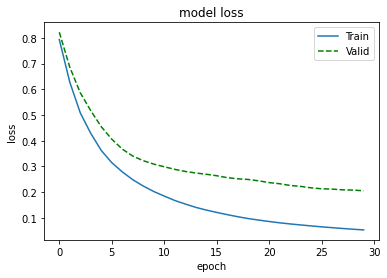

In [161]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], 'g--', label='Valid')
plt.legend()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

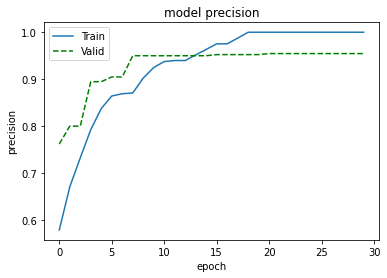

In [162]:
plt.plot(history.history['precision'], label='Train')
plt.plot(history.history['val_precision'], 'g--', label='Valid')
plt.legend()
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.show()

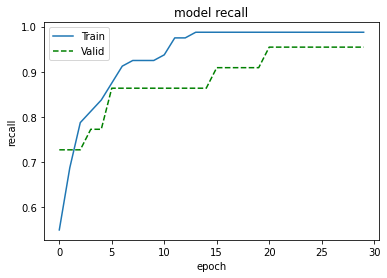

In [163]:
plt.plot(history.history['recall'], label='Train')
plt.plot(history.history['val_recall'], 'g--', label='Valid')
plt.legend()
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.show()

In [148]:
F1 = 2 * (np.multiply(history.history['precision'], history.history['recall'])) / np.sum((history.history['precision'], history.history['recall']))
val_F1 = 2 * (np.multiply(history.history['val_precision'], history.history['val_recall'])) / np.sum((history.history['val_precision'], history.history['val_recall']))

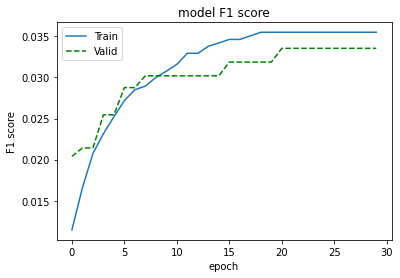

In [152]:
plt.plot(F1, label='Train')
plt.plot(val_F1, 'g--', label='Valid')
plt.legend()
plt.title('model F1 score')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.show()